<a href="https://colab.research.google.com/github/Ashbondre28/CODSOFT/blob/main/Fruit%20Quality%20Analysis%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pickle
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from google.colab import drive
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Define dataset path
dataset_path = '/content/gdrive/MyDrive/Quality/dataset/'
train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')

# Define Google Drive paths for saving/loading the model and label encoder
model_save_path = '/content/gdrive/MyDrive/Quality/best_model.keras'
encoder_save_path = '/content/gdrive/MyDrive/Quality/label_encoder.pkl'

# Check if the model and encoder already exist in Google Drive
if os.path.exists(model_save_path) and os.path.exists(encoder_save_path):
    print("Loading the pre-trained model and label encoder from Google Drive...")
    model = load_model(model_save_path)
    with open(encoder_save_path, "rb") as f:
        label_encoder = pickle.load(f)
else:
    print("Training the model from scratch...")

    # Data augmentation and data preparation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.2  # Split training data into train and validation
    )

    train_generator = datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='training',  # Training data
        shuffle=True
    )

    val_generator = datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='validation'  # Validation data
    )

    # Encode labels
    label_encoder = LabelEncoder()
    label_encoder.fit(list(train_generator.class_indices.keys()))

    # Save the label encoder
    with open(encoder_save_path, "wb") as f:
        pickle.dump(label_encoder, f)

    # Define the model using EfficientNetB0
    def create_model():
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        base_model.trainable = False  # Freeze base model initially
        model = Sequential([
            base_model,
            GlobalAveragePooling2D(),
            Dense(128, activation='relu'),
            Dropout(0.3),
            Dense(len(train_generator.class_indices), activation='softmax')  # Adjust output neurons to the number of classes
        ])
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    # Create and compile the model
    model = create_model()

    # Callbacks for saving the best model and early stopping
    checkpoint = ModelCheckpoint(model_save_path, save_best_only=True, monitor="val_accuracy", mode="max")
    early_stop = EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=20,
        callbacks=[checkpoint, early_stop]
    )

    # Plot training history
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Model Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

# Load the test data for evaluation
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Prediction function
def predict_image(img_path):
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    image = np.expand_dims(image, axis=0)

    # Predict the label
    pred = model.predict(image)
    label = label_encoder.inverse_transform([np.argmax(pred)])[0]

    # Display the image and prediction
    img = cv2.imread(img_path)
    output = cv2.resize(img, (400, 400))
    cv2.putText(output, f"Prediction: {label}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
    cv2_imshow(output)

Loading the pre-trained model and label encoder from Google Drive...
Found 280 images belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 80s 9s/step - accuracy: 0.9767 - loss: 0.0873
Test Accuracy: 97.14%


Saving test img.jpg to test img.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


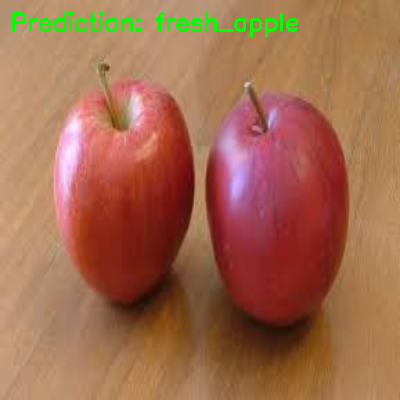

In [ ]:
# Test the prediction
from google.colab import files
uploaded = files.upload()
for filename in uploaded.keys():
    predict_image(filename)